# C++ Coursework: FFT and Numerical Integration Implementation

In `FFT.cpp` and its associated header and implementation files I have implemented a Cooley-Tukey Fast Fourier Transform algorithm and utilised the integration property of Fourier transforms to compute the acceleration spectrum of a seismogram and the associated velocity and displacement profiles in the Fourier and time domain. Let's go through some examples to assess the reliability of my impementation, comparing against the solution given by NumPy.

### A Simple Sinusoidal Case

For the function 

$$f(t) = sin(2\pi t),$$ 

$\ t \in [0,\ 2\pi],$ it is clear that the Fourier transform should present with a peak frequency at $\sim 1\ Hz$. Let's verify that my script can reproduce this simple case.


In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Generating our test data
t = np.linspace(0, 2*np.pi, 10000) 
f = np.sin(2*np.pi*t)

Note that the above results in $f_s = \frac{10000}{2\pi} \approx 1591.5 Hz$. With this data saved in `data/sine.txt`, we can run `FFT`, using the aforementioned $f_s$ where requested to produce `data/sine.txt_results/*`. Let's analyse the results: 

In [71]:
# Load our FFT data
with open("data/sine.txt_results/acc_spectrum.txt", "r") as reading:
    lines = [line.strip().split() for line in reading]
    cpp_amplitudes = np.array([float(line[0]) for line in lines])
    cpp_frequencies = np.array([float(line[1]) for line in lines])

# and generate FFT data using NumPy
fs = 1591.5 # Hz
numpy_amplitudes = abs(np.fft.rfft(f))  
numpy_frequencies = np.fft.rfftfreq(len(f), d=1/fs)  

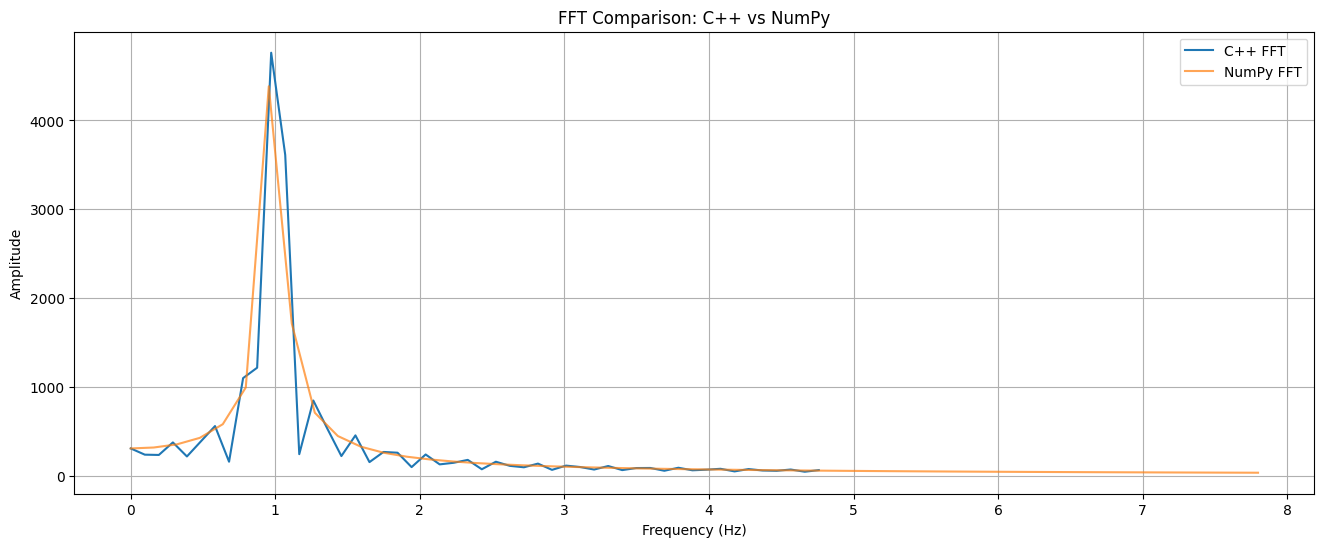

In [72]:
# And plotting 

plt.figure(figsize=(16, 6))
plt.plot(cpp_frequencies[:50], cpp_amplitudes[:50], label="C++ FFT")
plt.plot(numpy_frequencies[:50], numpy_amplitudes[:50], label="NumPy FFT", alpha=0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT Comparison: C++ vs NumPy")
plt.legend()
plt.grid()
plt.show()

While not a perfect match, our FFT algorithm produces a clear spike at 1 Hz as expected. Note that `cpp_frequencies[:50]` does not have the same extent as the FFT resamples the length $N$ input signal to ensure $N = 2^n, n \in \mathbb{R}$. 

Let's compare the residuals of the means.

In [73]:
print(sum(numpy_amplitudes)/len(numpy_amplitudes) - sum(cpp_amplitudes)/len(cpp_amplitudes))

0.24251306351748791


Not bad.

### A Real Case: Loma Prieta Earthquake of 1989.

Let's plot our original accelerogram.

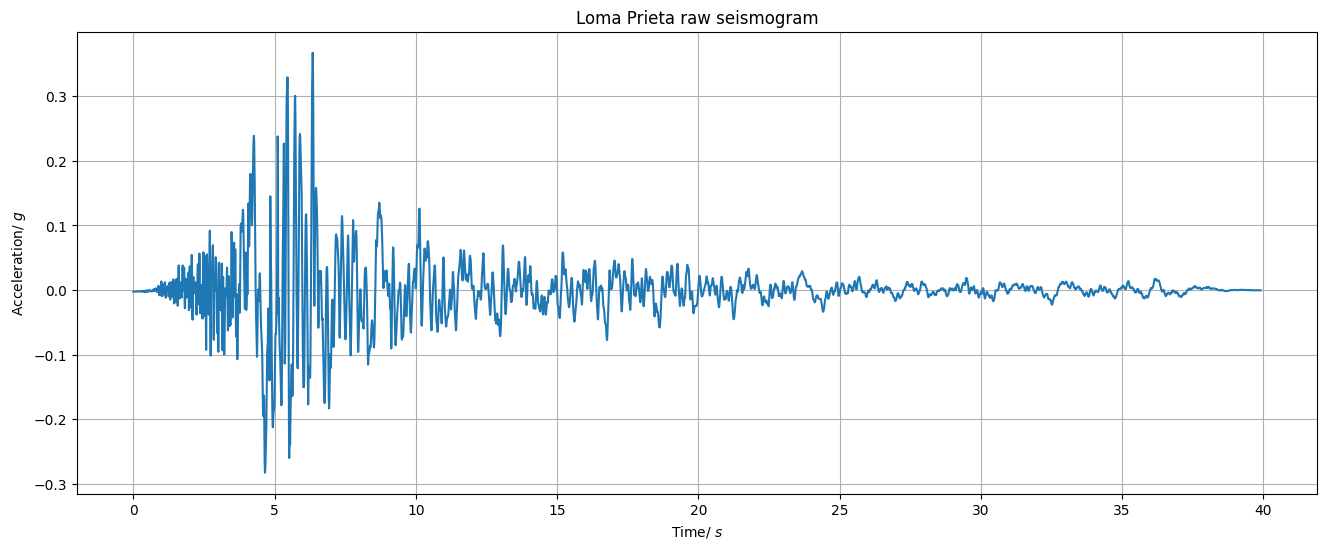

In [74]:
with open("data/Loma_Prieta.dat", "r") as reading:
    lines = [line.strip().split() for line in reading.readlines()[5:]]
    loma_time = np.array([float(line[0]) for line in lines])
    loma_acceleration = np.array([float(line[1]) for line in lines])

plt.figure(figsize=(16, 6))
plt.plot(loma_time, loma_acceleration)
plt.xlabel("Time/ $s$")
plt.ylabel("Acceleration/ $g$")
plt.title("Loma Prieta raw seismogram")
plt.grid()
plt.show()

In [75]:
# Find the numpy FFT solution
fs = 100 # Hz
loma_acc = abs(np.fft.rfft(loma_acceleration))  
loma_freq = np.fft.rfftfreq(len(loma_acceleration), d=1/fs)  

Upon examination of the data file, it is clear that we should use $f_s = 100Hz$, and we will use a tapering constant $k$ of 1. Let's look at the results!

In [76]:
with open("data/Loma_Prieta.dat_results/acc_spectrum.txt", "r") as reading:
    lines = [line.strip().split() for line in reading.readlines()]
    acceleration = np.array([float(line[0]) for line in lines])
    frequency = np.array([float(line[1]) for line in lines])

with open("data/Loma_Prieta.dat_results/vel_spectrum.txt", "r") as reading:
    velocity = np.array([float(line.strip().split()[0]) for line in reading])

with open("data/Loma_Prieta.dat_results/disp_spectrum.txt", "r") as reading:
    displacement = np.array([float(line.strip().split()[0]) for line in reading])

Text(0.5, 0, 'Frequency')

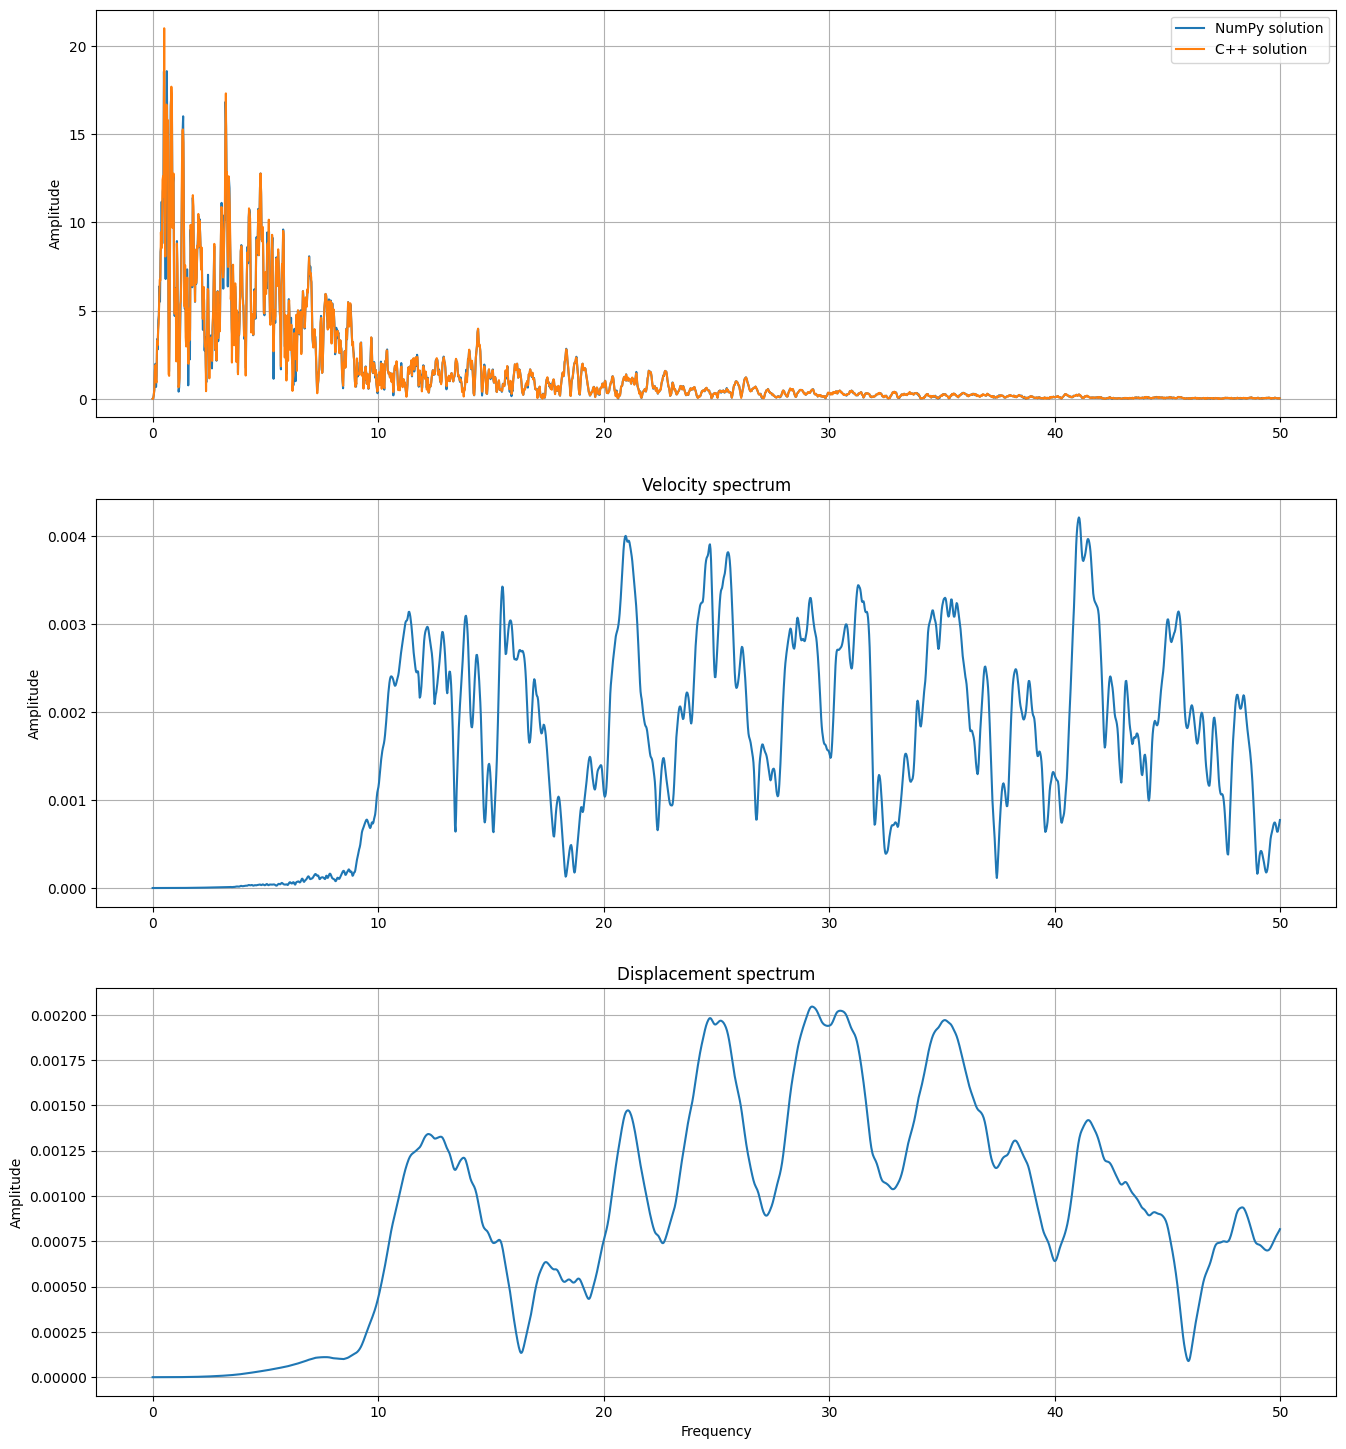

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,18))

def plot_this(x, y, ax, lbl, legend, title):
    ax.plot(x, y, label = str(lbl))
    ax.set_ylabel("Amplitude")
    ax.set_title(str(title))
    ax.grid(True)

    if legend is True:
        ax.legend()

plot_this(loma_freq, loma_acc, ax1, "NumPy solution", False, "Acceleration spectrum")
plot_this(frequency, acceleration, ax1, "C++ solution", True, "")


plot_this(frequency, velocity, ax2, "C++ solution", False, "Velocity spectrum")
plot_this(frequency, displacement, ax3, "C++ solution", False, "Displacement spectrum")
ax3.set_xlabel("Frequency")

And how does the residual of the mean look?

In [78]:
print(sum(acceleration)/len(acceleration) - sum(loma_acc)/len(loma_acc))

-0.0015468284171979985


Nice.

Let's finally look at how my FFT algorithm computes the inverse. We can mess about with `main()` to ensure `padData` is inversely transformed by setting its flag to be 1 and similarly for `computeAmplitudes()` in order to create `Loma_Prieta.dat_results/acc_time.txt` which is the accelerogram reconstructred by our inverse FFT routine.

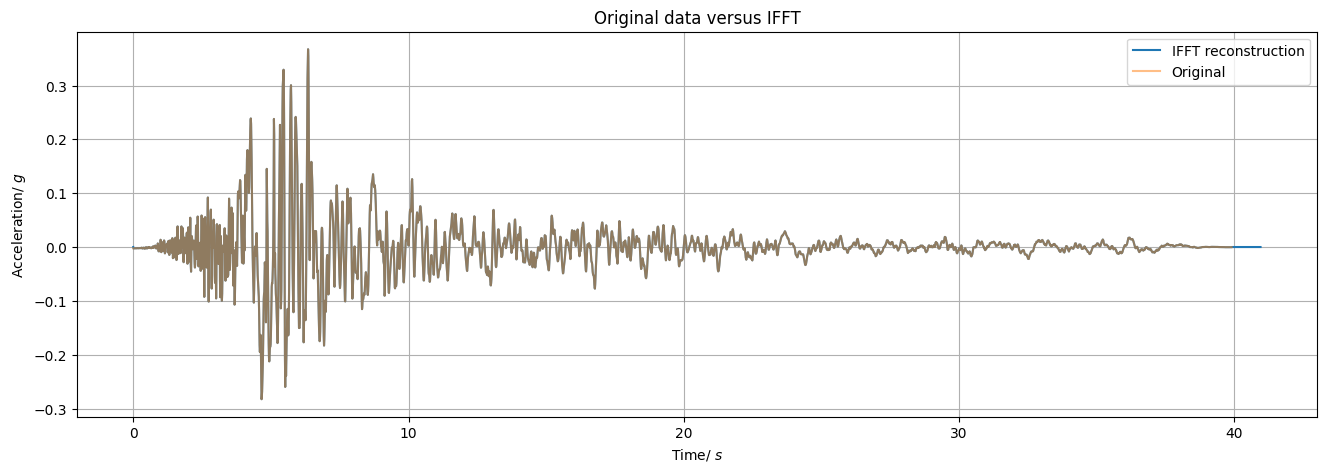

In [79]:
with open("data/Loma_Prieta.dat_results/KEEP_acc_time.txt", "r") as reading:
    lines = [line.strip().split() for line in reading.readlines() if not line.startswith('#')]
    acceleration = np.array([float(line[0]) for line in lines])
    time = np.array([float(line[1]) for line in lines])

plt.figure(figsize=(16, 5))
plt.plot(time, acceleration, label="IFFT reconstruction")
plt.plot(loma_time, loma_acceleration, label="Original", alpha=0.5)
plt.xlabel("Time/ $s$")
plt.ylabel("Acceleration/ $g$")
plt.title("Original data versus IFFT")
plt.grid()
plt.legend()
plt.show()

A near perfect match! Good. Let's compare residuals.

In [80]:
print(sum(acceleration)/len(acceleration) - sum(loma_acceleration)/len(loma_acceleration))

5.859436172773219e-07


Great! Our inverse FFT algorithm works to a realiable extent.